In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd

from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [2]:
RED = 0
GREEN = 1
BLUE = 2

dataset_path = Path('./sign_data/')
if not dataset_path.joinpath('data').exists():
    dataset_path = Path('./')

In [4]:
# Read the parquet file, this takes a while. Leave it here
features_file = dataset_path.joinpath("data/train_features.parquet")
test_file = dataset_path.joinpath("data/test_features.parquet")
meta_file = dataset_path.joinpath("data/meta_full.parquet")

# dft = pl.read_parquet(features_file, use_pyarrow=True, memory_map=True)
# dfm = pl.read_parquet(meta_file, use_pyarrow=True, memory_map=True)
dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dfe = pl.read_parquet(test_file, memory_map=True)

dft = dft.join(dfm, on="ClassId")
dfe = dfe.join(dfm, on="ClassId")

del dfm

In [5]:
# To do: select 200 random images from each class
features = dft.filter(
    pl.int_range(0, pl.count()).shuffle().over("ClassId") < 200
)
testfeat = dft.filter(
    pl.int_range(0, pl.count()).shuffle().over("ClassId") < 40
)

In [51]:
# Test distribution:
# features.groupby("ClassId").agg(pl.count())
# testfeat.groupby("ClassId").agg(pl.count())


In [6]:
features.head(3)

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[247, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]",[binary data],"[56, 112, … 0]","[0.318327, 0.160083, … 0.28708]",[binary data],"[0.318798, 0.301229, … 0.194583]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""C:\Users\teddy…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096
0,20,64,64,[binary data],4096,[binary data],"[250, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]",[binary data],"[57, 127, … 0]","[0.295379, 0.246268, … 0.106746]",[binary data],"[0.342584, 0.329293, … 0.204987]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""C:\Users\teddy…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096
0,20,64,64,[binary data],4096,[binary data],"[232, 0, … 0]","[22, 0, … 0]","[0, 0, … 0]",[binary data],"[73, 130, … 0]","[0.356871, 0.0, … 0.017861]",[binary data],"[0.32187, 0.308041, … 0.225191]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""C:\Users\teddy…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [54]:
# testfeat.head(3)

In [7]:
columns = ['ClassId', 'Hue_Hist', 'Saturation_Hist', 'Value_Hist', 'LBP_Hist', 'HOG_Features',
           'Template_Pattern', 'RESNET101', 'VGG16'
          ]
features = features[columns]
features.head(3)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Hist,HOG_Features,Template_Pattern,RESNET101,VGG16
i64,list[i64],list[i64],list[i64],list[i64],list[f32],list[f32],list[f64],list[f64]
20,"[247, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]","[56, 112, … 0]","[0.318327, 0.160083, … 0.28708]","[0.318798, 0.301229, … 0.194583]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"
20,"[250, 0, … 0]","[30, 0, … 0]","[0, 0, … 0]","[57, 127, … 0]","[0.295379, 0.246268, … 0.106746]","[0.342584, 0.329293, … 0.204987]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"
20,"[232, 0, … 0]","[22, 0, … 0]","[0, 0, … 0]","[73, 130, … 0]","[0.356871, 0.0, … 0.017861]","[0.32187, 0.308041, … 0.225191]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]"


In [56]:
def build_model(num_features, learning_rate=.001):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(
        units=43,                     # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We'll use SGD
    # We will specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. This finalizes the graph for training.
    # We specify the MSE loss.
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [57]:
# Run base model per feature (excluding pattern matching)
# Using Train sample (200 images per class)
NUM_BATCH = 32
EPSILON = 0.0001
EPOCHS = 50
SPLIT = 0.10

params = []
for col in columns:
    learningRate = EPSILON
    epochs = EPOCHS
    
    if col == 'HOG_Features':
        learningRate = 0.1
    elif col == 'LBP_Hist':
        learningRate = 0.01
        epochs = 10
    elif col == 'Template_Pattern':
        learningRate = 0.01
        epochs = 60
    elif col == 'RESNET101':
        learningRate = 0.001
        epochs = 90
        
    params.append([col, learningRate, epochs])

    
models = []

for col in columns[1:]:
    train_features, labels = features[col], features['ClassId']
    split = int(train_features.shape[0] * SPLIT)
    val_features, v_labels = train_features[-split:], labels[-split:]
    train_features, t_labels = train_features[:-split], labels[:-split]
   
    tdataset = tf.data.Dataset.from_tensors(((np.vstack(train_features)), t_labels))
    vdataset = tf.data.Dataset.from_tensors(((np.vstack(val_features)), v_labels))
    
    tdataset.batch(NUM_BATCH)
    
    parmts = [e for e in params if e[0]==col][0]
    learningRate = parmts[1]
    epochs = parmts[2]
    
    print(f'Model for {col}')
    print('='*100)
    num_features = train_features[0].len()
    model = build_model(num_features, learningRate)
    
    history = model.fit(tdataset, epochs=epochs, verbose=1, validation_data=vdataset)
    models.append((model, history, col, learningRate))
    print('='*100, '\n\n')


Model for Hue_Hist
Epoch 1/50


2023-12-03 00:44:08.254727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 443ms/step - loss: 16631417.0000 - val_loss: 1786575.5000
Epoch 2/50
1/1 [==============================] - 0s 18ms/step - loss: 2306901.0000 - val_loss: 929762.0000
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 775274.2500 - val_loss: 759014.3125
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 526204.3125 - val_loss: 672424.8125
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 428919.2812 - val_loss: 609357.1875
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 364826.7500 - val_loss: 551602.7500
Epoch 7/50
1/1 [==============================] - 0s 17ms/step - loss: 316676.0000 - val_loss: 502273.5000


2023-12-03 00:44:08.681729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


Epoch 8/50
1/1 [==============================] - 0s 20ms/step - loss: 279005.4688 - val_loss: 459080.0312
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 248756.6719 - val_loss: 421312.9062
Epoch 10/50
1/1 [==============================] - 0s 21ms/step - loss: 223925.4531 - val_loss: 388019.7188
Epoch 11/50
1/1 [==============================] - 0s 19ms/step - loss: 203148.9844 - val_loss: 358526.8750
Epoch 12/50
1/1 [==============================] - 0s 20ms/step - loss: 185483.0000 - val_loss: 332271.2812
Epoch 13/50
1/1 [==============================] - 0s 17ms/step - loss: 170260.8281 - val_loss: 308805.1250
Epoch 14/50
1/1 [==============================] - 0s 21ms/step - loss: 157002.0312 - val_loss: 287760.3125
Epoch 15/50
1/1 [==============================] - 0s 20ms/step - loss: 145352.6562 - val_loss: 268831.6875
Epoch 16/50
1/1 [==============================] - 0s 22ms/step - loss: 135045.5938 - val_loss: 251762.4531
Epoch 17/50
1/1 [=============

2023-12-03 00:44:10.216941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-03 00:44:10.407472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 241ms/step - loss: 16631417.0000 - val_loss: 4472114.0000
Epoch 2/50
1/1 [==============================] - 0s 16ms/step - loss: 4344147.5000 - val_loss: 1691231.0000
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 1404315.2500 - val_loss: 1031718.9375
Epoch 4/50
1/1 [==============================] - 0s 18ms/step - loss: 675016.3750 - val_loss: 851389.5000
Epoch 5/50
1/1 [==============================] - 0s 18ms/step - loss: 472462.7188 - val_loss: 775871.8750
Epoch 6/50
1/1 [==============================] - 0s 17ms/step - loss: 398369.9062 - val_loss: 722798.0000
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 357839.2188 - val_loss: 675396.7500
Epoch 8/50
1/1 [==============================] - 0s 17ms/step - loss: 327793.3125 - val_loss: 630842.4375
Epoch 9/50
1/1 [==============================] - 0s 17ms/step - loss: 302299.4375 - val_loss: 588892.8125
Epoch 10/50
1/1 [=======================

2023-12-03 00:44:11.766783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-03 00:44:11.952328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 244ms/step - loss: 16631417.0000 - val_loss: 4490336.5000
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 4600671.5000 - val_loss: 2145716.5000
Epoch 3/50
1/1 [==============================] - 0s 16ms/step - loss: 2187493.7500 - val_loss: 1272256.8750
Epoch 4/50
1/1 [==============================] - 0s 16ms/step - loss: 1268028.5000 - val_loss: 900769.1875
Epoch 5/50
1/1 [==============================] - 0s 17ms/step - loss: 865087.3125 - val_loss: 710372.2500
Epoch 6/50
1/1 [==============================] - 0s 17ms/step - loss: 656381.5000 - val_loss: 592726.1250
Epoch 7/50
1/1 [==============================] - 0s 16ms/step - loss: 529237.9375 - val_loss: 509567.4062
Epoch 8/50
1/1 [==============================] - 0s 16ms/step - loss: 441766.7500 - val_loss: 446051.6875
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: 376787.8125 - val_loss: 395485.8438
Epoch 10/50
1/1 [======================

2023-12-03 00:44:13.565096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 309ms/step - loss: 16631417.0000 - val_loss: 1577789816832.0000
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 1649616486400.0000 - val_loss: 158054349816201216.0000
Epoch 3/10
1/1 [==============================] - 0s 46ms/step - loss: 165155631563538432.0000 - val_loss: 15824902618941686284288.0000
Epoch 4/10


2023-12-03 00:44:13.812929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 52ms/step - loss: 16535272276665437257728.0000 - val_loss: 1584383174645378725124767744.0000
Epoch 5/10
1/1 [==============================] - 0s 51ms/step - loss: 1655501128433680043984551936.0000 - val_loss: 158627460567553322093059306946560.0000
Epoch 6/10
1/1 [==============================] - 0s 50ms/step - loss: 165747714488667109669976561156096.0000 - val_loss: inf
Epoch 7/10
1/1 [==============================] - 0s 50ms/step - loss: inf - val_loss: inf
Epoch 8/10
1/1 [==============================] - 0s 44ms/step - loss: inf - val_loss: inf
Epoch 9/10
1/1 [==============================] - 0s 37ms/step - loss: inf - val_loss: inf
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: inf - val_loss: inf


Model for HOG_Features
Epoch 1/50


2023-12-03 00:44:15.545722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 360ms/step - loss: 86430.4766 - val_loss: 49172.2461
Epoch 2/50
1/1 [==============================] - 0s 38ms/step - loss: 55554.7070 - val_loss: 31019.6250
Epoch 3/50
1/1 [==============================] - 0s 35ms/step - loss: 35768.5977 - val_loss: 19512.0488
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 23088.0996 - val_loss: 12236.1768
Epoch 5/50


2023-12-03 00:44:15.854343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 40ms/step - loss: 14960.5137 - val_loss: 7651.1748
Epoch 6/50
1/1 [==============================] - 0s 36ms/step - loss: 9750.2402 - val_loss: 4774.0942
Epoch 7/50
1/1 [==============================] - 0s 38ms/step - loss: 6409.2856 - val_loss: 2978.5391
Epoch 8/50
1/1 [==============================] - 0s 35ms/step - loss: 4266.1753 - val_loss: 1865.8361
Epoch 9/50
1/1 [==============================] - 0s 36ms/step - loss: 2890.6587 - val_loss: 1182.6610
Epoch 10/50
1/1 [==============================] - 0s 37ms/step - loss: 2007.0587 - val_loss: 768.3721
Epoch 11/50
1/1 [==============================] - 0s 35ms/step - loss: 1438.7346 - val_loss: 521.3602
Epoch 12/50
1/1 [==============================] - 0s 35ms/step - loss: 1072.5007 - val_loss: 377.5657
Epoch 13/50
1/1 [==============================] - 0s 37ms/step - loss: 835.8309 - val_loss: 296.7682
Epoch 14/50
1/1 [==============================] - 0s 35ms/step - loss: 682.2501 - v

2023-12-03 00:44:19.346616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 310ms/step - loss: 555733.2500 - val_loss: 511915.9062
Epoch 2/60
1/1 [==============================] - 0s 48ms/step - loss: 464598.6562 - val_loss: 426345.6875
Epoch 3/60
1/1 [==============================] - 0s 49ms/step - loss: 388431.1875 - val_loss: 354982.9688
Epoch 4/60


2023-12-03 00:44:19.609234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 49ms/step - loss: 324772.5938 - val_loss: 295481.4062
Epoch 5/60
1/1 [==============================] - 0s 51ms/step - loss: 271568.5312 - val_loss: 245881.2344
Epoch 6/60
1/1 [==============================] - 0s 46ms/step - loss: 227102.0781 - val_loss: 204545.4062
Epoch 7/60
1/1 [==============================] - 0s 42ms/step - loss: 189938.1562 - val_loss: 170106.7500
Epoch 8/60
1/1 [==============================] - 0s 43ms/step - loss: 158877.4688 - val_loss: 141423.3281
Epoch 9/60
1/1 [==============================] - 0s 47ms/step - loss: 132917.5938 - val_loss: 117541.6250
Epoch 10/60
1/1 [==============================] - 0s 48ms/step - loss: 111220.8594 - val_loss: 97665.3750
Epoch 11/60
1/1 [==============================] - 0s 49ms/step - loss: 93087.1016 - val_loss: 81129.7422
Epoch 12/60
1/1 [==============================] - 0s 51ms/step - loss: 77931.1250 - val_loss: 67379.6641
Epoch 13/60
1/1 [==============================] -

2023-12-03 00:44:25.981227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 309ms/step - loss: 4816.3613 - val_loss: 2263.8818
Epoch 2/90
1/1 [==============================] - 0s 53ms/step - loss: 4629.5034 - val_loss: 2136.4502
Epoch 3/90
1/1 [==============================] - 0s 56ms/step - loss: 4450.1216 - val_loss: 2015.2057
Epoch 4/90


2023-12-03 00:44:26.245115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 58ms/step - loss: 4277.9160 - val_loss: 1899.8794
Epoch 5/90
1/1 [==============================] - 0s 55ms/step - loss: 4112.6011 - val_loss: 1790.2120
Epoch 6/90
1/1 [==============================] - 0s 57ms/step - loss: 3953.8999 - val_loss: 1685.9575
Epoch 7/90
1/1 [==============================] - 0s 59ms/step - loss: 3801.5491 - val_loss: 1586.8781
Epoch 8/90
1/1 [==============================] - 0s 54ms/step - loss: 3655.2932 - val_loss: 1492.7461
Epoch 9/90
1/1 [==============================] - 0s 56ms/step - loss: 3514.8896 - val_loss: 1403.3431
Epoch 10/90
1/1 [==============================] - 0s 54ms/step - loss: 3380.1028 - val_loss: 1318.4617
Epoch 11/90
1/1 [==============================] - 0s 54ms/step - loss: 3250.7090 - val_loss: 1237.9015
Epoch 12/90
1/1 [==============================] - 0s 55ms/step - loss: 3126.4929 - val_loss: 1161.4703
Epoch 13/90
1/1 [==============================] - 0s 54ms/step - loss: 3007.2466

1/1 [==============================] - 0s 54ms/step - loss: 303.5560 - val_loss: 79.5745
Epoch 85/90
1/1 [==============================] - 0s 53ms/step - loss: 297.2491 - val_loss: 83.5191
Epoch 86/90
1/1 [==============================] - 0s 53ms/step - loss: 291.1946 - val_loss: 87.5057
Epoch 87/90
1/1 [==============================] - 0s 55ms/step - loss: 285.3820 - val_loss: 91.5286
Epoch 88/90
1/1 [==============================] - 0s 55ms/step - loss: 279.8019 - val_loss: 95.5826
Epoch 89/90
1/1 [==============================] - 0s 57ms/step - loss: 274.4451 - val_loss: 99.6623
Epoch 90/90
1/1 [==============================] - 0s 53ms/step - loss: 269.3024 - val_loss: 103.7631


Model for VGG16
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 34913.6523

2023-12-03 00:44:31.800127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [7740]
	 [[{{node Placeholder/_1}}]]
2023-12-03 00:44:31.992318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [860]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 241ms/step - loss: 34913.6523 - val_loss: 25140.6484
Epoch 2/50
1/1 [==============================] - 0s 19ms/step - loss: 32378.6973 - val_loss: 23069.4492
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 30028.4375 - val_loss: 21159.2773
Epoch 4/50
1/1 [==============================] - 0s 19ms/step - loss: 27849.4258 - val_loss: 19398.0078
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 25829.1699 - val_loss: 17774.4375
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 23956.1094 - val_loss: 16278.1836
Epoch 7/50
1/1 [==============================] - 0s 19ms/step - loss: 22219.5234 - val_loss: 14899.6396
Epoch 8/50
1/1 [==============================] - 0s 19ms/step - loss: 20609.4629 - val_loss: 13629.8984
Epoch 9/50
1/1 [==============================] - 0s 19ms/step - loss: 19116.7109 - val_loss: 12460.7305
Epoch 10/50
1/1 [==============================] - 0s 20ms/step -

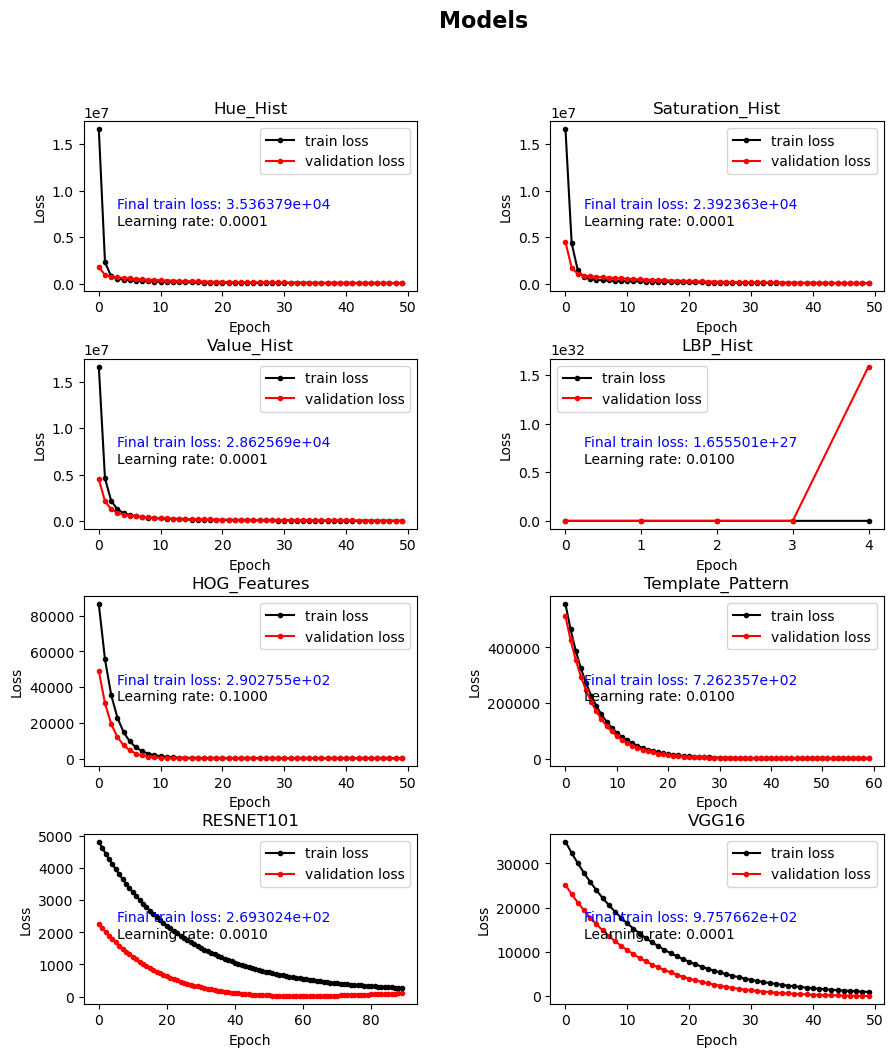

In [58]:
plt.figure(figsize=(10,14))
plt.suptitle("Models", fontsize=16, color="black", fontweight="bold")

for i,m in enumerate(models):
    hist = pd.DataFrame(m[1].history)   
    hist = hist[np.isfinite(hist).all(1)]
    
    ax = plt.subplot(5, 2, i+1)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(hist)), hist['loss'], marker='.', color='black')
    plt.plot(range(len(hist)), hist['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.title(m[2])
    
    loss = "Final train loss: {lo:e}"
    loss = loss.format(lo=list(hist['loss'])[-1])

    lrate = "Learning rate: {ep:.4f}"
    lrate = lrate.format(ep=m[3])

    plt.text(0.1, 0.55, loss,
             ha='left', va='top',
             transform=ax.transAxes,
             color='blue'
            )
    plt.text(0.1, 0.45, lrate,
             ha='left', va='top',
             transform=ax.transAxes,
             color='black'
            )

    
plt.subplots_adjust(left=0.1, 
                bottom=0.1,  
                right=0.9,  
                top=0.9,  
                wspace=0.4,  
                hspace=0.4) 
    
plt.show()


In [69]:
hist = pd.DataFrame(models[4][1].history)
hist.tail(5)

,loss,val_loss
45,300.254211,235.552948
46,297.702209,234.669937
47,295.189270,233.812378
48,292.714142,232.980545
49,290.275513,232.174484


In [67]:
# Make predictions on test data using HOG Features
# test_features, labels = testfeat['HOG_Features'], testfeat['ClassId']
# tdataset = tf.data.Dataset.from_tensors(((np.vstack(test_features)), t_labels))

# model = models[4][0]
# modelname = models[4][2]
# print(modelname)

# test_loss = model.evaluate(x=tdataset, verbose=0)

# test_rmse = np.sqrt(test_loss)
# print('Test rmse:', test_rmse)


In [68]:
models[4][0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                125431    
                                                                 
Total params: 125,431
Trainable params: 125,431
Non-trainable params: 0
_________________________________________________________________
